# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                                                
Sample_153  P0DOY3                                                                                           23.137
Sample_074  A0A0G2JHN4;A0A0G2JII5;A0A0G2JIT9;A0A0G2JJ47;A0A0G2JJK2;A0A0G2JJZ1;A0A0G2JP87;A0A0G2JPU2;B0S7V6   18.063
Sample_084  Q9UQ52                                                                                           15.544
Sample_009  P07093-2;P07093-3                                                                                13.852
Sample_140  H7BZJ3                                                                                           17.501
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups             
Sample_126  O75051;O75051-2               13.626
Sample_179  G3V295;G3V3I1;G3V5Z7;P60900   11.722
Sample_138  Q9NZU1                        13.178
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.171
            A0A075B6Q5                 13.631
            A0A075B6R2                 13.195
            A0A075B6S5                 11.621
            A0A087WSY4                 11.908
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.963
            Q9UI40;Q9UI40-2            12.467
            Q9UIW2                     13.459
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.365
            Q9UP79                     12.965
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.096,15.050,16.842,19.863,15.761,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.710,19.067,...,15.528,15.576,14.275,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.403,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.741,17.705,17.039,16.152,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.067,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.306,15.345,17.084,18.708,14.249,19.433,11.948,11.232
Sample_207,15.739,16.877,15.469,16.898,14.861,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.187,13.117,11.612,13.733,11.166,13.256,13.352,12.925,12.232,12.943
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.174,19.067,16.127,...,13.401,13.189,12.948,12.407,14.095,11.986,11.879,14.102,13.145,12.937
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.936,13.210,13.672,12.329,12.125,11.840,13.849,11.627,12.764,13.491
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.069,13.842,11.873,13.302,12.108,13.628,14.075,12.636,13.070,12.672
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,14.075,13.553,12.985,13.003,12.534,12.349,13.254,12.696,13.358,13.690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.760,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 395.20it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.29it/s]

100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.82it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.12it/s]

100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.90it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.06it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.46it/s]

100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

100%|██████████| 5/5 [00:01<00:00,  3.49it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.20it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.74it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.17it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.55it/s]

100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.01it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.52it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.07it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.52it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.36it/s]

100%|██████████| 7/7 [00:01<00:00,  3.25it/s]

100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.23it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.18it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.91it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.02it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.99it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.93it/s]

100%|██████████| 8/8 [00:02<00:00,  2.87it/s]

100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.46it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.64it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.27it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.30it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.36it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.82it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.71it/s]

100%|██████████| 9/9 [00:02<00:00,  2.66it/s]

100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.79it/s]

 30%|███       | 3/10 [00:00<00:01,  5.64it/s]

 40%|████      | 4/10 [00:00<00:01,  4.73it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.56it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.49it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.39it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.55it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.57it/s]

100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

100%|██████████| 10/10 [00:02<00:00,  4.71it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.90it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.62it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.37it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.86it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.23it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.44it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.61it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.76it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.29it/s]

100%|██████████| 11/11 [00:01<00:00,  6.33it/s]

100%|██████████| 11/11 [00:01<00:00,  6.40it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.62it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.83it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.32it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.75it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.54it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.52it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.27it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.09it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.17it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.69it/s]

100%|██████████| 12/12 [00:02<00:00,  3.63it/s]

100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.13it/s]

 31%|███       | 4/13 [00:00<00:01,  5.73it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.07it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.82it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.95it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.89it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.68it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.25it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.49it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.63it/s]

100%|██████████| 13/13 [00:02<00:00,  4.59it/s]

100%|██████████| 13/13 [00:02<00:00,  4.86it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.46it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.02it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.53it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.58it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.84it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.96it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  4.02it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.67it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.73it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.87it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.96it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.05it/s]

100%|██████████| 14/14 [00:03<00:00,  4.09it/s]

100%|██████████| 14/14 [00:03<00:00,  3.96it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.32it/s]

 20%|██        | 3/15 [00:00<00:03,  3.81it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.33it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.19it/s]

 40%|████      | 6/15 [00:01<00:02,  3.11it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.87it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.82it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.17it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.49it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.73it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.91it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.00it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.04it/s]

100%|██████████| 15/15 [00:04<00:00,  4.08it/s]

100%|██████████| 15/15 [00:04<00:00,  3.59it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.038 0.007          0.858 0.238       0.153   
2             0.004 0.002      0.047 0.016          0.666 0.115       0.512   
3             0.004 0.003      0.047 0.016          0.781 0.103       0.767   
4             0.003 0.000      0.039 0.011          0.801 0.094       0.774   
5             0.005 0.005      0.051 0.020          0.774 0.092       0.780   
6             0.004 0.003      0.045 0.017          0.773 0.092       0.774   
7             0.004 0.000      0.042 0.014          0.775 0.094       0.776   
8             0.008 0.008      0.073 0.031          0.810 0.096       0.791   
9             0.005 0.004      0.067 0.030          0.806 0.090       0.803   
10            0.004 0.002      0.036 0.008          0.803 0.090       0.803   
11            0.003 0.001      0.033 0.004          0.823 0.084       0.803   
12            0.003 0.001      0.030 0.004          0.830 0.083       0.803   
13            0.005 0.004      0.041 0.014          0.824 0.089       0.815   
14            0.006 0.005      0.052 0.017          0.818 0.084       0.815   
15            0.006 0.006      0.053 0.022          0.820 0.084       0.811   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.251 0.126                  0.568 0.043        0.851   
2          0.124   0.568 0.098                  0.659 0.062        0.726   
3          0.105   0.768 0.078                  0.802 0.065        0.882   
4          0.105   0.782 0.076                  0.814 0.062        0.887   
5          0.093   0.772 0.068                  0.804 0.058        0.893   
6          0.088   0.769 0.064                  0.801 0.054        0.891   
7          0.085   0.771 0.065                  0.803 0.055        0.890   
8          0.094   0.796 0.071                  0.825 0.060        0.911   
9          0.078   0.800 0.061                  0.828 0.053        0.910   
10         0.080   0.799 0.061                  0.826 0.053        0.908   
11         0.084   0.809 0.063                  0.836 0.054        0.921   
12         0.084   0.813 0.065                  0.840 0.055        0.920   
13         0.089   0.816 0.068                  0.842 0.058        0.920   
14         0.092   0.813 0.067                  0.840 0.056        0.919   
15         0.096   0.811 0.069                  0.839 0.058        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.089        210.000 0.000  
2          0.071                  0.675 0.082        210.000 0.000  
3          0.056                  0.843 0.083        210.000 0.000  
4          0.051                  0.855 0.074        210.000 0.000  
5          0.048                  0.856 0.069        210.000 0.000  
6          0.048                  0.854 0.070        210.000 0.000  
7          0.048                  0.852 0.070        210.000 0.000  
8          0.045                  0.888 0.058        210.000 0.000  
9          0.045                  0.890 0.058        210.000 0.000  
10         0.045                  0.889 0.058        210.000 0.000  
11         0.043                  0.910 0.047        210.000 0.000  
12         0.044                  0.907 0.051        210.000 0.000  
13         0.046                  0.905 0.053        210.000 0.000  
14         0.046                  0.905 0.053        210.000 0.000  
15         0.046                  0.903 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 510.50it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.35it/s]

100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.02it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.30it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.05it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.68it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.56it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.81it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.99it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.47it/s]

100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.54it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.95it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.02it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.05it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.15it/s]

100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.23it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.17it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.42it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.11it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.94it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.85it/s]

100%|██████████| 8/8 [00:01<00:00,  3.68it/s]

100%|██████████| 8/8 [00:01<00:00,  4.10it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.54it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.93it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.50it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.74it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.51it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.68it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.62it/s]

100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.95it/s]

 30%|███       | 3/10 [00:00<00:01,  3.51it/s]

 40%|████      | 4/10 [00:01<00:02,  2.93it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.91it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.00it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.22it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.31it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.37it/s]

100%|██████████| 10/10 [00:03<00:00,  3.35it/s]

100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.89it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.15it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.75it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.69it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.88it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.88it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.74it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.68it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.55it/s]

100%|██████████| 11/11 [00:02<00:00,  3.75it/s]

100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.62it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.01it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.26it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.00it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.88it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.00it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.30it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.32it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.42it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.39it/s]

100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

100%|██████████| 12/12 [00:03<00:00,  3.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.08it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.98it/s]

 31%|███       | 4/13 [00:00<00:01,  5.07it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.37it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.26it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.35it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.81it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.53it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.50it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.86it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.99it/s]

100%|██████████| 13/13 [00:03<00:00,  3.22it/s]

100%|██████████| 13/13 [00:03<00:00,  3.37it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.52it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.28it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.56it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.26it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.99it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.00it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.86it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.42it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.14it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.81it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.75it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.60it/s]

100%|██████████| 14/14 [00:04<00:00,  2.83it/s]

100%|██████████| 14/14 [00:04<00:00,  3.37it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.68it/s]

 20%|██        | 3/15 [00:00<00:03,  3.99it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.91it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.51it/s]

 40%|████      | 6/15 [00:01<00:02,  3.64it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.76it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.77it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.81it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.82it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.83it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.82it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.89it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.87it/s]

100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

100%|██████████| 15/15 [00:03<00:00,  3.85it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.051 0.016          0.000 0.000       0.000   
2             0.004 0.002      0.042 0.013          0.813 0.093       0.704   
3             0.004 0.004      0.042 0.014          0.774 0.100       0.710   
4             0.004 0.003      0.044 0.016          0.765 0.100       0.689   
5             0.005 0.004      0.044 0.015          0.828 0.091       0.742   
6             0.003 0.000      0.036 0.005          0.818 0.099       0.756   
7             0.003 0.001      0.031 0.005          0.819 0.091       0.772   
8             0.004 0.002      0.034 0.004          0.817 0.092       0.774   
9             0.004 0.002      0.037 0.010          0.806 0.099       0.755   
10            0.004 0.003      0.036 0.016          0.811 0.097       0.770   
11            0.004 0.004      0.040 0.016          0.810 0.095       0.764   
12            0.004 0.003      0.037 0.010          0.826 0.094       0.786   
13            0.004 0.002      0.042 0.018          0.837 0.088       0.812   
14            0.004 0.001      0.037 0.009          0.841 0.086       0.817   
15            0.005 0.003      0.049 0.017          0.844 0.084       0.814   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.862   
2          0.108   0.748 0.078                  0.791 0.060        0.867   
3          0.114   0.734 0.083                  0.776 0.067        0.876   
4          0.124   0.719 0.093                  0.765 0.074        0.877   
5          0.107   0.778 0.076                  0.813 0.062        0.906   
6          0.106   0.781 0.081                  0.815 0.066        0.905   
7          0.101   0.790 0.074                  0.822 0.060        0.905   
8          0.099   0.791 0.074                  0.822 0.062        0.902   
9          0.107   0.774 0.080                  0.808 0.066        0.900   
10         0.111   0.786 0.088                  0.818 0.071        0.901   
11         0.107   0.782 0.085                  0.815 0.070        0.900   
12         0.101   0.801 0.077                  0.831 0.064        0.925   
13         0.096   0.820 0.070                  0.846 0.060        0.930   
14         0.097   0.824 0.068                  0.850 0.059        0.932   
15         0.098   0.824 0.069                  0.850 0.059        0.932   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.829 0.085        210.000 0.000  
2          0.060                  0.838 0.080        210.000 0.000  
3          0.050                  0.849 0.068        210.000 0.000  
4          0.051                  0.852 0.061        210.000 0.000  
5          0.048                  0.888 0.056        210.000 0.000  
6          0.048                  0.886 0.059        210.000 0.000  
7          0.047                  0.886 0.058        210.000 0.000  
8          0.048                  0.884 0.058        210.000 0.000  
9          0.051                  0.881 0.060        210.000 0.000  
10         0.049                  0.885 0.055        210.000 0.000  
11         0.050                  0.883 0.056        210.000 0.000  
12         0.043                  0.907 0.054        210.000 0.000  
13         0.041                  0.913 0.046        210.000 0.000  
14         0.040                  0.914 0.045        210.000 0.000  
15         0.040                  0.914 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1118.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 22.80it/s]

100%|██████████| 3/3 [00:00<00:00, 22.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.98it/s]

100%|██████████| 4/4 [00:00<00:00, 16.73it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 25.33it/s]

100%|██████████| 5/5 [00:00<00:00, 20.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.87it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.28it/s]

100%|██████████| 6/6 [00:00<00:00, 14.59it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.82it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.83it/s]

100%|██████████| 7/7 [00:00<00:00, 16.36it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.68it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.45it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.28it/s]

100%|██████████| 8/8 [00:00<00:00, 13.52it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 23.76it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 18.60it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 17.10it/s]

100%|██████████| 9/9 [00:00<00:00, 17.50it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.31it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.26it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.90it/s]

100%|██████████| 10/10 [00:00<00:00, 14.71it/s]

100%|██████████| 10/10 [00:00<00:00, 15.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.76it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.86it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 15.23it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 15.39it/s]

100%|██████████| 11/11 [00:00<00:00, 15.48it/s]

100%|██████████| 11/11 [00:00<00:00, 15.65it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.38it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.24it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 16.23it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.01it/s]

100%|██████████| 12/12 [00:00<00:00, 15.19it/s]

100%|██████████| 12/12 [00:00<00:00, 15.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.87it/s]

 46%|████▌     | 6/13 [00:00<00:00, 18.34it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.30it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.30it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.62it/s]

100%|██████████| 13/13 [00:00<00:00, 15.06it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 16.39it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.00it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.07it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.21it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.89it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.30it/s]

100%|██████████| 14/14 [00:01<00:00, 12.07it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.72it/s]

 40%|████      | 6/15 [00:00<00:00, 13.72it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.93it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 13.05it/s]

 80%|████████  | 12/15 [00:00<00:00, 11.99it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.62it/s]

100%|██████████| 15/15 [00:01<00:00, 12.61it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.034 0.010          0.000 0.000       0.000   
2             0.005 0.005      0.044 0.015          0.633 0.124       0.439   
3             0.004 0.002      0.041 0.013          0.678 0.122       0.471   
4             0.005 0.007      0.041 0.014          0.676 0.113       0.462   
5             0.003 0.001      0.041 0.013          0.711 0.100       0.549   
6             0.004 0.002      0.041 0.011          0.712 0.101       0.556   
7             0.005 0.004      0.044 0.014          0.709 0.102       0.549   
8             0.004 0.003      0.040 0.009          0.728 0.096       0.625   
9             0.004 0.003      0.046 0.018          0.721 0.095       0.619   
10            0.004 0.003      0.041 0.016          0.709 0.083       0.655   
11            0.005 0.004      0.052 0.017          0.707 0.088       0.653   
12            0.004 0.001      0.036 0.007          0.712 0.086       0.656   
13            0.008 0.006      0.063 0.020          0.706 0.094       0.635   
14            0.004 0.002      0.041 0.017          0.704 0.088       0.633   
15            0.005 0.005      0.052 0.027          0.700 0.089       0.636   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.730   
2          0.114   0.509 0.096                  0.622 0.063        0.710   
3          0.112   0.548 0.102                  0.651 0.067        0.749   
4          0.108   0.541 0.095                  0.648 0.061        0.750   
5          0.120   0.613 0.093                  0.692 0.065        0.780   
6          0.114   0.617 0.087                  0.693 0.061        0.777   
7          0.119   0.611 0.092                  0.690 0.064        0.775   
8          0.112   0.667 0.084                  0.725 0.063        0.810   
9          0.119   0.659 0.088                  0.720 0.066        0.804   
10         0.113   0.675 0.084                  0.729 0.063        0.813   
11         0.115   0.674 0.088                  0.727 0.067        0.812   
12         0.116   0.677 0.086                  0.730 0.065        0.807   
13         0.120   0.661 0.087                  0.719 0.065        0.804   
14         0.119   0.660 0.084                  0.718 0.062        0.800   
15         0.119   0.659 0.082                  0.716 0.062        0.798   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.681 0.087        210.000 0.000  
2          0.078                  0.619 0.099        210.000 0.000  
3          0.074                  0.662 0.097        210.000 0.000  
4          0.073                  0.665 0.097        210.000 0.000  
5          0.075                  0.693 0.099        210.000 0.000  
6          0.074                  0.692 0.097        210.000 0.000  
7          0.074                  0.690 0.098        210.000 0.000  
8          0.064                  0.739 0.088        210.000 0.000  
9          0.066                  0.732 0.089        210.000 0.000  
10         0.066                  0.753 0.092        210.000 0.000  
11         0.067                  0.752 0.093        210.000 0.000  
12         0.067                  0.747 0.092        210.000 0.000  
13         0.068                  0.748 0.092        210.000 0.000  
14         0.067                  0.741 0.093        210.000 0.000  
15         0.065                  0.740 0.088 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,5,13
score_time,8,1,13
test_precision,1,15,8
test_recall,14,14,12
test_f1,13,14,12
test_balanced_accuracy,13,15,12
test_roc_auc,11,14,10
test_average_precision,11,14,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.33it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.08it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.78it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.77it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.83it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.96it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.91it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.94it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.40it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.08it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.01it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.86it/s]

100%|██████████| 14/14 [00:04<00:00,  2.64it/s]

100%|██████████| 14/14 [00:04<00:00,  3.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.35it/s]

 60%|██████    | 6/10 [00:00<00:00, 13.55it/s]

 80%|████████  | 8/10 [00:00<00:00, 12.47it/s]

100%|██████████| 10/10 [00:00<00:00, 12.20it/s]

100%|██████████| 10/10 [00:00<00:00, 12.46it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.60it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.88it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.17it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.89it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.98it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.85it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.00it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.06it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.16it/s]

100%|██████████| 11/11 [00:02<00:00,  4.24it/s]

100%|██████████| 11/11 [00:02<00:00,  4.23it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


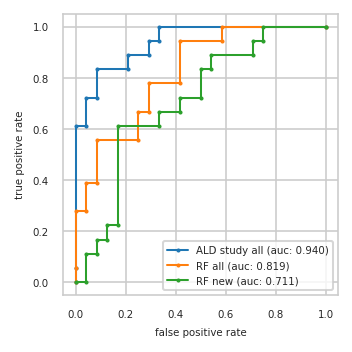

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.611  0.000 0.278  0.042 0.111
3          0.042 0.611  0.042 0.278  0.083 0.111
4          0.042 0.722  0.042 0.389  0.083 0.167
5          0.083 0.722  0.083 0.389  0.125 0.167
6          0.083 0.833  0.083 0.556  0.125 0.222
7          0.208 0.833  0.250 0.556  0.167 0.222
8          0.208 0.889  0.250 0.667  0.167 0.611
9          0.292 0.889  0.292 0.667  0.333 0.611
10         0.292 0.944  0.292 0.778  0.333 0.667
11         0.333 0.944  0.417 0.778  0.417 0.667
12         0.333 1.000  0.417 0.944  0.417 0.722
13         1.000 1.000  0.583 0.944  0.500 0.722
14           NaN   NaN  0.583 1.000  0.500 0.833
15           NaN   NaN  1.000 1.000  0.542 0.833
16           NaN   NaN    NaN   NaN  0.542 0.889
17           NaN   NaN    NaN   NaN  0.708 0.889
18           NaN   NaN    NaN   NaN  0.708 0.944
19           NaN   NaN    NaN   NaN  0.750 0.944
20           NaN   NaN    NaN   NaN  0.750 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NZ53,Q8NFY4;Q8NFY4-6,P30048;P30048-2
2,Q92743,Q12797;Q12797-10,J3KSJ8;Q9UD71;Q9UD71-2
3,P04075,P61981,P51688
4,Q16674;W4VSR3,Q9Y2T3;Q9Y2T3-3,P31321
5,P61981,P04075,Q96GD0
6,P14174,P14174,Q9NUQ9
7,P08294,P15151-2,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,Q9Y2T3;Q9Y2T3-3,Q14894,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


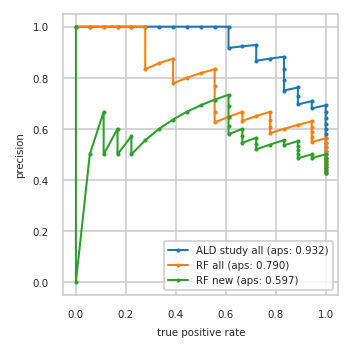

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.548 0.944     0.516 0.889
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.667 1.000     0.630 0.944     0.556 0.833
16         0.692 1.000     0.615 0.889     0.538 0.778
17         0.680 0.944     0.600 0.833     0.520 0.722
18         0.708 0.944     0.583 0.778     0.542 0.722
19         0.696 0.889     0.609 0.778     0.565 0.722
20         0.727 0.889     0.636 0.778     0.545 0.667
21         0.762 0.889     0.667 0.778     0.571 0.667
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.789 0.833     0.632 0.667     0.579 0.611
24         0.833 0.833     0.667 0.667     0.611 0.611
25         0.882 0.833     0.647 0.611     0.647 0.611
26         0.875 0.778     0.625 0.556     0.688 0.611
27         0.867 0.722     0.667 0.556     0.733 0.611
28         0.929 0.722     0.714 0.556     0.714 0.556
29         0.923 0.667     0.769 0.556     0.692 0.500
30         0.917 0.611     0.833 0.556     0.667 0.444
31         1.000 0.611     0.818 0.500     0.636 0.389
32         1.000 0.556     0.800 0.444     0.600 0.333
33         1.000 0.500     0.778 0.389     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


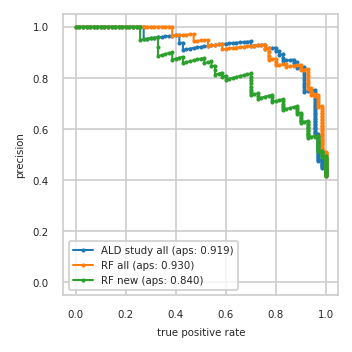

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


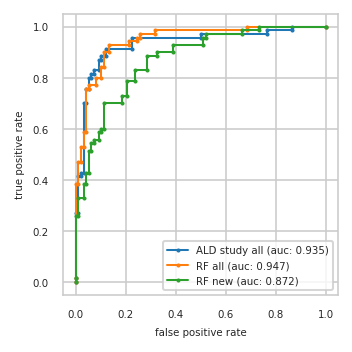

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}